In [6]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from CNN2D import *
import pandas as pd
import numpy as np
import torch.utils.data as utils
import time
import os
import pickle

import pdb

# For the notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

torch.manual_seed(1)

## TRAIN SET

In [7]:
gt_train_coord = pickle.load( open( "./import_dataset_2/train/gt_train_coord.pkl", "rb" ) )
gt_train  = pickle.load( open( "./import_dataset_2/train/gt_train.pkl", "rb" ) )
in_train_coord  = pickle.load( open( "./import_dataset_2/train/in_train_coord.pkl", "rb" ) )
inputs_train = pickle.load( open( "./import_dataset_2/train/inputs_train.pkl", "rb" ) )

inputs_train = torch.from_numpy(inputs_train).float()
gt_train = torch.from_numpy(gt_train).float()

gt_train = gt_train.unsqueeze(1) # add 1 dimension to the training set
inputs_train = inputs_train.unsqueeze(1) # add 1 dimension to the training set

inputs_train.shape,gt_train.shape

(torch.Size([5157, 1, 10, 164]), torch.Size([5157, 1, 11, 4]))

## VALIDATION SET

In [8]:
gt_validation_coord = pickle.load( open( "./import_dataset_2/validation/gt_validation_coord.pkl", "rb" ) )
gt_validation = pickle.load( open( "./import_dataset_2/validation/gt_validation.pkl", "rb" ) )
in_validation_coord = pickle.load( open( "./import_dataset_2/validation/in_validation_coord.pkl", "rb" ) )
inputs_validation = pickle.load( open( "./import_dataset_2/validation/inputs_validation.pkl", "rb" ) )

inputs_validation = torch.from_numpy(inputs_validation).float()
gt_validation = torch.from_numpy(gt_validation).float()

gt_validation = gt_validation.unsqueeze(1) # add 1 dimension to the training set
inputs_validation = inputs_validation.unsqueeze(1) # add 1 dimension to the training set
print (inputs_validation.shape)

gt_validation_coord.shape,gt_validation.shape,in_validation_coord.shape,inputs_validation.shape

torch.Size([1719, 1, 10, 164])


((11, 1719, 2),
 torch.Size([1719, 1, 11, 4]),
 (10, 1719, 2),
 torch.Size([1719, 1, 10, 164]))

## TEST SET

In [13]:
gt_test_coord_1 = pickle.load( open( "./import_dataset_2/test/gt_test_coord_1.pkl", "rb" ) )
gt_test_1 = pickle.load( open( "./import_dataset_2/test/gt_test_1.pkl", "rb" ) )
in_test_coord_1 = pickle.load( open( "./import_dataset_2/test/in_test_coord_1.pkl", "rb" ) )
inputs_test_1 = pickle.load( open( "./import_dataset_2/test/inputs_test_1.pkl", "rb" ) )

gt_test_coord_2 = pickle.load( open( "./import_dataset_2/test/gt_test_coord_2.pkl", "rb" ) )
gt_test_2 = pickle.load( open( "./import_dataset_2/test/gt_test_2.pkl", "rb" ) )
in_test_coord_2 = pickle.load( open( "./import_dataset_2/test/in_test_coord_2.pkl", "rb" ) )
inputs_test_2 = pickle.load( open( "./import_dataset_2/test/inputs_test_2.pkl", "rb" ) )

gt_test_coord_3 = pickle.load( open( "./import_dataset_2/test/gt_test_coord_3.pkl", "rb" ) )
gt_test_3 = pickle.load( open( "./import_dataset_2/test/gt_test_3.pkl", "rb" ) )
in_test_coord_3 = pickle.load( open( "./import_dataset_2/test/in_test_coord_3.pkl", "rb" ) )
inputs_test_3 = pickle.load( open( "./import_dataset_2/test/inputs_test_3.pkl", "rb" ) )

inputs_test_1 = torch.from_numpy(inputs_test_1).float()
gt_test_1 = torch.from_numpy(gt_test_1).float()
inputs_test_1 = inputs_test_1.unsqueeze(1) 

inputs_test_2 = torch.from_numpy(inputs_test_2).float()
gt_test_2 = torch.from_numpy(gt_test_2).float()
inputs_test_2 = inputs_test_2.unsqueeze(1)

inputs_test_3 = torch.from_numpy(inputs_test_3).float()
gt_test_3 = torch.from_numpy(gt_test_3).float()
inputs_test_3 = inputs_test_3.unsqueeze(1)
print (inputs_test_3.shape)

torch.Size([10, 1, 460, 164])


### Model

In [22]:
net = CNN2D()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-4)

traindataset = utils.TensorDataset(inputs_train, gt_train[:,:,1:,:])
trainloader = utils.DataLoader(traindataset, batch_size=16, shuffle=True)

valdataset = utils.TensorDataset(inputs_validation, gt_validation[:,:,1:,:])
valloader = utils.DataLoader(valdataset, batch_size=16, shuffle=True)

In [23]:
epochs = 150
steps = 0
running_loss = 0
print_every = 323
loss_train = []
loss_val = []

for e in range(epochs):
    start = time.time()
    steps_bis = 0
    total_train_loss=0
    for train_coord, ground_tru in iter(trainloader):
        
        steps += 1
        steps_bis += 1
        
        input_train = Variable(train_coord)
        in_train = input_train.squeeze(1)
        target = Variable(ground_tru)
        targets = target.squeeze(1)
        optimizer.zero_grad()
        out = net.forward(input_train)
        out = out.reshape(out.shape[0],10,4)
        out_bis = out[:,:,0:2].clone()  
        for i in range(10):
            if i == 0:
                out_bis[:, i, 0:2] = in_train[:, -1, 0:2] + out[:, i, 2:]*0.4
            else:
                out_bis[:, i, 0:2] = out[:, i - 1, 0:2] + out[:, i, 2:]*0.4
        
        loss1 = (criterion(out[:,:,0:2], targets[:,:,0:2]))
        loss2 = (criterion(out[:,:,2:], targets[:,:,2:]))
        loss3 = criterion(out_bis, targets[:,:,0:2])
        
        loss1.backward(retain_graph=True)
        loss2.backward(retain_graph=True)
        loss3.backward(retain_graph=True)
        optimizer.step()
        
        running_loss += (loss1+loss2+loss3).item()
        total_train_loss += (loss1+loss2+loss3).item()
        
        if steps % print_every == 0:
            stop = time.time()
            val_loss=0
            
            for ii, (images, labels) in enumerate(valloader):
                
                inp = Variable(images)
                input_val = inp.squeeze(1)
                lab = Variable(labels)
                valgt = lab.squeeze(1)
                predicted = net.predict(inp)
                predicted = predicted.reshape(predicted.shape[0],10,4)
                predicted_bis = predicted[:,:,0:2].clone()
                #print(out_bis.shape)   
                for i in range(10):
                    if i == 0:
                        predicted_bis[:, i, 0:2] = input_val[:, -1, 0:2] + predicted[:, i, 2:]*0.4
                    else:
                        predicted_bis[:, i, 0:2] = predicted[:, i - 1, 0:2] + predicted[:, i, 2:]*0.4
                val_loss+= (criterion(predicted[:,:,0:2],valgt[:,:,0:2]).item()
                                + criterion(predicted[:,:,2:],valgt[:,:,2:]).item()
                                + criterion(predicted_bis, valgt[:,:,0:2]).item())
                
            print("Epoch: {}/{}..".format(e+1, epochs),
                  "Validation Loss: {:.4f}..".format(val_loss/ii),
                  "Training Loss: {:.4f}..".format(running_loss/print_every),
                  "{:.4f} s/batch ".format((stop - start)/print_every),
                 )
            loss_val.append(val_loss/ii)
            running_loss = 0
            start = time.time()
    loss_train.append(total_train_loss/steps_bis)

Epoch: 1/150.. Validation Loss: 5.3887.. Training Loss: 7.7658.. 0.0221 s/batch 
Epoch: 2/150.. Validation Loss: 3.9014.. Training Loss: 4.5708.. 0.0294 s/batch 
Epoch: 3/150.. Validation Loss: 3.0371.. Training Loss: 3.3891.. 0.0379 s/batch 
Epoch: 4/150.. Validation Loss: 2.5261.. Training Loss: 2.7192.. 0.0383 s/batch 
Epoch: 5/150.. Validation Loss: 2.1773.. Training Loss: 2.2926.. 0.0364 s/batch 
Epoch: 6/150.. Validation Loss: 1.9978.. Training Loss: 2.0424.. 0.0328 s/batch 
Epoch: 7/150.. Validation Loss: 1.9827.. Training Loss: 1.8714.. 0.0375 s/batch 
Epoch: 8/150.. Validation Loss: 1.7523.. Training Loss: 1.7367.. 0.0343 s/batch 
Epoch: 9/150.. Validation Loss: 1.7581.. Training Loss: 1.6648.. 0.0357 s/batch 
Epoch: 10/150.. Validation Loss: 1.6167.. Training Loss: 1.5739.. 0.0335 s/batch 
Epoch: 11/150.. Validation Loss: 1.6400.. Training Loss: 1.4864.. 0.0344 s/batch 
Epoch: 12/150.. Validation Loss: 1.4745.. Training Loss: 1.3992.. 0.0345 s/batch 
Epoch: 13/150.. Validatio

Epoch: 102/150.. Validation Loss: 0.8375.. Training Loss: 0.4880.. 0.0202 s/batch 
Epoch: 103/150.. Validation Loss: 0.8471.. Training Loss: 0.4888.. 0.0200 s/batch 
Epoch: 104/150.. Validation Loss: 0.8517.. Training Loss: 0.4921.. 0.0200 s/batch 
Epoch: 105/150.. Validation Loss: 0.8305.. Training Loss: 0.4916.. 0.0205 s/batch 
Epoch: 106/150.. Validation Loss: 0.8378.. Training Loss: 0.4819.. 0.0198 s/batch 
Epoch: 107/150.. Validation Loss: 0.8624.. Training Loss: 0.4766.. 0.0195 s/batch 
Epoch: 108/150.. Validation Loss: 0.8375.. Training Loss: 0.4765.. 0.0195 s/batch 
Epoch: 109/150.. Validation Loss: 0.8328.. Training Loss: 0.4784.. 0.0196 s/batch 
Epoch: 110/150.. Validation Loss: 0.8026.. Training Loss: 0.4769.. 0.0196 s/batch 
Epoch: 111/150.. Validation Loss: 0.8390.. Training Loss: 0.4739.. 0.0207 s/batch 
Epoch: 112/150.. Validation Loss: 0.8249.. Training Loss: 0.4708.. 0.0197 s/batch 
Epoch: 113/150.. Validation Loss: 0.8370.. Training Loss: 0.4707.. 0.0196 s/batch 
Epoc

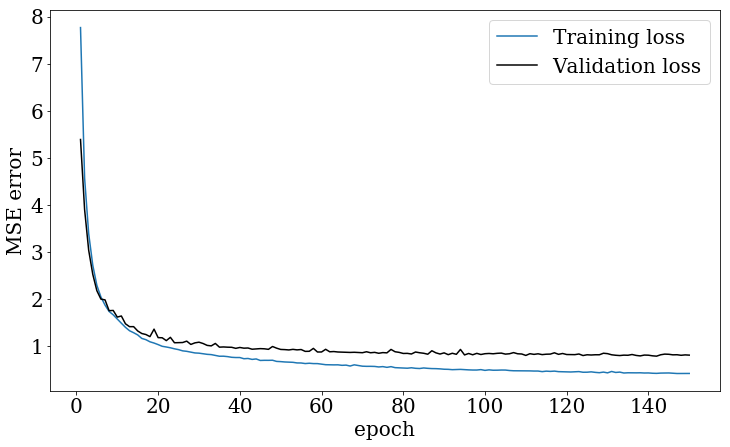

In [24]:
epoch = np.arange(1,epochs+1)
plt.figure(figsize=(12, 7))
plt.rc('font', family='serif')
plt.rc('font', size=20)

plt.plot(epoch,loss_train,label='Training loss')
plt.plot(epoch,loss_val,c='k',label='Validation loss')
plt.xlabel('epoch')
plt.ylabel('MSE error')
plt.legend()

In [19]:
output_test_1 = net.predict(inputs_test_1)
output_test_1 = output_test_1.data.numpy()
output_test_1 = np.reshape(output_test_1,(250,10,4))

output_test_2 = net.predict(inputs_test_2)
output_test_2 = output_test_2.data.numpy()
output_test_2 = np.reshape(output_test_2,(1006,10,4))

output_test_3 = net.predict(inputs_test_3)
output_test_3 = output_test_3.data.numpy()
output_test_3 = np.reshape(output_test_3,(460,10,4))

## Post processing step
Go back to coordinate:
We have Vx and Vy and we want x and y.
$ V = d/t$
$ d = V*t$
Here t = 0.4s between each point.
Start from data at index 9. Then we add d_x and d_y to the last x and y.

##### Type 1 trajectory

In [20]:
output_coord_1=np.zeros([11,inputs_test_1.shape[2],2])
for j in range(11):
    for i in range(output_test_1.shape[2]):
        if j==0:
            output_coord_1[j,i,0:2] = in_test_coord_1[9,i,0:2]
        else:
            #pdb.set_trace()
            output_coord_1[j,i,0:2] = output_coord_1[j-1,i,0:2]+output_test_1[i,j-1,2:]*0.4
print(output_coord_1)        

[[[ 0.06        0.02      ]
  [ 0.00894427  0.0491935 ]
  [ 0.          0.        ]
  ...
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.04597479  0.07554098]
  [ 0.02285544  0.18330188]
  [-0.01394021  0.18845606]
  ...
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.01296235  0.26127845]
  [ 0.03933112  0.43012678]
  [-0.03282522  0.4080845 ]
  ...
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 ...

 [[ 0.13870919  1.09810914]
  [-0.62712589  1.53473233]
  [ 0.00499434  0.54440208]
  ...
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.12502852  1.17163045]
  [-0.75364807  1.69790631]
  [-0.10754205  0.391691  ]
  ...
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.14979232  1.17120671]
  [-0.88062574  1.7512803 ]
  [-0.23111668  0.20943203]
  ...
  [ 0.          0.      

In [21]:
dist = np.zeros(inputs_test_1.shape[2])
for i in range(inputs_test_1.shape[2]):
    dist[i] = np.sqrt(sum((gt_test_coord_1[10,i,:]-output_coord_1[10,i,:])**2))

final_coord_error = np.mean(dist)
print('The final distance between the ground trought and the predicted coordinates is :',final_coord_error.round(3))

The final distance between the ground trought and the predicted coordinates is : 0.599


In [58]:
avr = np.zeros((inputs_test_1.shape[2],11))
for i in range(inputs_test_1.shape[2]):
    for j in range(11):
        avr[i,j] = np.sqrt(sum((gt_test_coord_1[j,i,:]-output_coord_1[j,i,:])**2))

average = np.mean(np.mean(avr,1))
print('The average error between the ground trought and the predicted coordinates is :',average.round(3))

The average error between the ground trought and the predicted coordinates is : 0.512


(-0.13970358335482888,
 0.7337752504514066,
 -0.27637536472082136,
 5.8038826591372485)

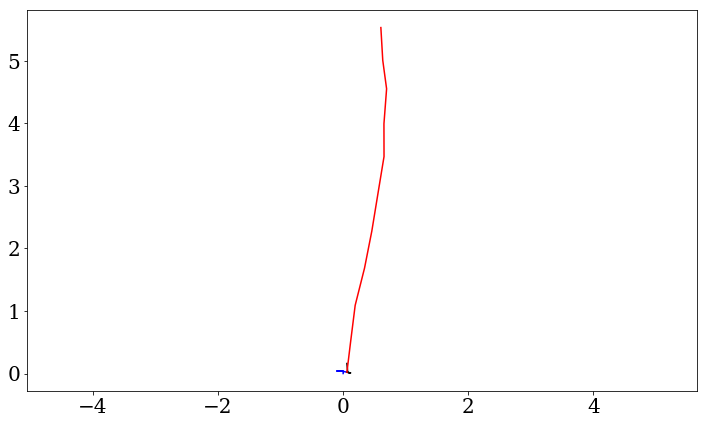

In [59]:
plt.figure(figsize=(12, 7))
plt.rc('font', family='serif')
plt.rc('font', size=20)

ind = np.random.randint(inputs_test_1.shape[1])

plt.plot(in_test_coord_1[:,ind,0],in_test_coord_1[:,ind,1],c='b')
plt.plot(gt_test_coord_1[:,ind,0],gt_test_coord_1[:,ind,1],c='k')
plt.plot(output_coord_1[:,ind,0],output_coord_1[:,ind,1],c='r')
plt.axis('equal')

In [60]:
output_coord_2=np.zeros([11,inputs_test_2.shape[2],2])
for j in range(11):
    for i in range(output_test_2.shape[2]):
        if j==0:
            output_coord_2[j,i,0:2] = in_test_coord_2[9,i,0:2]
        else:
            output_coord_2[j,i,0:2] = output_coord_2[j-1,i,0:2]+output_test_2[i,j-1,2:]*0.4
        

In [61]:
dist = np.zeros(inputs_test_2.shape[2])
for i in range(inputs_test_2.shape[2]):
    dist[i] = np.sqrt(sum((gt_test_coord_2[10,i,:]-output_coord_2[10,i,:])**2))

final_coord_error = np.mean(dist)
print('The final distance between the ground trought and the predicted coordinates is :',final_coord_error.round(3))

The final distance between the ground trought and the predicted coordinates is : 7.016


In [62]:
avr = np.zeros((inputs_test_2.shape[1],11))
for i in range(inputs_test_2.shape[1]):
    for j in range(11):
        avr[i,j] = np.sqrt(sum((gt_test_coord_2[j,i,:]-output_coord_2[j,i,:])**2))

average = np.mean(np.mean(avr,1))
print('The average error between the ground trought and the predicted coordinates is :',average.round(3))

The average error between the ground trought and the predicted coordinates is : 2.196


(-0.10866605070319557, 2.281987064767107, -0.5169107140000001, 10.855124994)

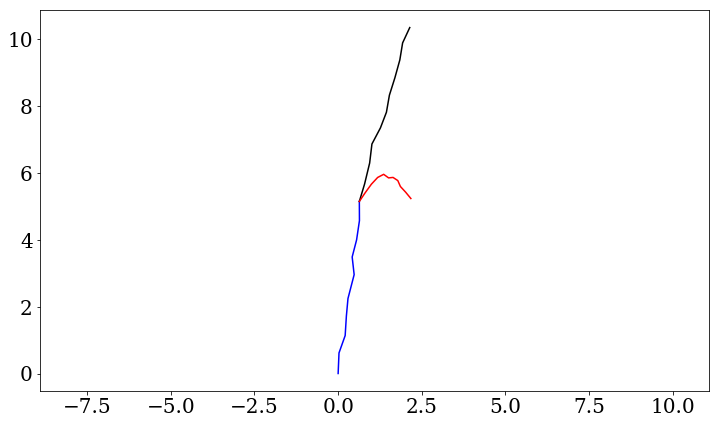

In [63]:
plt.figure(figsize=(12, 7))
plt.rc('font', family='serif')
plt.rc('font', size=20)

ind = np.random.randint(inputs_test_2.shape[1])

plt.plot(in_test_coord_2[:,ind,0],in_test_coord_2[:,ind,1],c='b')
plt.plot(gt_test_coord_2[:,ind,0],gt_test_coord_2[:,ind,1],c='k')
plt.plot(output_coord_2[:,ind,0],output_coord_2[:,ind,1],c='r')
plt.axis('equal')

In [73]:
output_coord_3=np.zeros([11,inputs_test_3.shape[2],2])
for j in range(11):
    for i in range(output_test_3.shape[2]):
        if j==0:
            output_coord_3[j,i,0:2] = in_test_coord_3[9,i,0:2]
        else:
            output_coord_3[j,i,0:2] = output_coord_3[j-1,i,0:2]+output_test_3[i,j-1,2:]*0.4
        

In [74]:
dist = np.zeros(inputs_test_3.shape[2])
for i in range(inputs_test_3.shape[2]):
    dist[i] = np.sqrt(sum((gt_test_coord_3[10,i,:]-output_coord_3[10,i,:])**2))

final_coord_error = np.mean(dist)
print('The final distance between the ground trought and the predicted coordinates is :',final_coord_error.round(3))

The final distance between the ground trought and the predicted coordinates is : 4.973


In [75]:
avr = np.zeros((inputs_test_3.shape[1],11))
for i in range(inputs_test_3.shape[1]):
    for j in range(11):
        avr[i,j] = np.sqrt(sum((gt_test_coord_3[j,i,:]-output_coord_3[j,i,:])**2))

average = np.mean(np.mean(avr,1))
print('The average error between the ground trought and the predicted coordinates is :',average.round(3))

The average error between the ground trought and the predicted coordinates is : 0.757


[[[-0.44878094  2.02912955]
  [-0.04801265  3.9600362 ]
  [-0.49563999  5.01835162]
  ...
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[-0.32800333  2.13485279]
  [-0.04232301  4.11956711]
  [-0.61762824  5.49063498]
  ...
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[-0.24218544  2.26975311]
  [-0.0528269   4.56373535]
  [-0.81112827  5.97971485]
  ...
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 ...

 [[ 0.33591969  3.3014394 ]
  [-0.35474862  6.95468671]
  [-1.16672139  9.49012539]
  ...
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.33167921  3.52524965]
  [-0.14585417  7.36364691]
  [-0.96257985 10.07725803]
  ...
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.26817882  3.75899561]
  [ 0.15690709  7.73558773]
  [-0.73402007 10.66332099]
  ...
  [ 0.          0.      

(-0.03802198800000001, 0.798461748, -0.6177760509649277, 12.973297070263481)

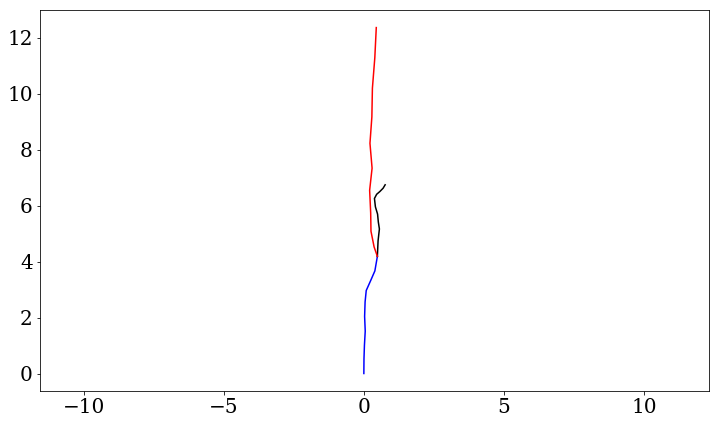

In [87]:
plt.figure(figsize=(12, 7))
plt.rc('font', family='serif')
plt.rc('font', size=20)

ind = np.random.randint(inputs_test_3.shape[0])

plt.plot(in_test_coord_3[:,ind,0],in_test_coord_3[:,ind,1],c='b')
plt.plot(gt_test_coord_3[:,ind,0],gt_test_coord_3[:,ind,1],c='k')
plt.plot(output_coord_3[:,ind,0],output_coord_3[:,ind,1],c='r')
plt.axis('equal')

In [25]:
torch.save(net.state_dict(), 'fullCNN_4.pt')

In [5]:
a=np.zeros([3,251,2])
a

array([[[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]])